## Support Vector Machines Notebook

### Description:

This notebook aims to implement **Support Vector Machines** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **Support Vector Machines** are capable of forecasting both stationary and non stationary series.

### SVM Brief Introduction


# COMPLETE -> attention, we are using the SVR - Support Vector Regressor, not SVC Classifierr

In [1]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm    # For SVR regressor
import sklearn.model_selection # hyperparameter search

### Some useful functions -> COMPLETE WITH MORE IF NEEDED AND DELETE ONES NOT NEEDED

In [2]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

# #Ploting a single time series
# def plot_series(serie,title,xlabel,ylabel):
#     fig = plt.figure()
#     plt.plot(serie)
#     fig.suptitle(title, fontsize=20)
#     plt.xlabel(xlabel, fontsize=18)
#     plt.ylabel(ylabel, fontsize=18)
#     plt.show()

#plot two time series
def plot_2_series(real,model,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()
    plt.plot(real)
    plt.plot(model)
    fig.suptitle(title, fontsize=20)
    # plt.xlabel(xlabel, fontsize=18)
    # plt.ylabel(ylabel, fontsize=18)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series


#normalize time series values into range [0,1]
def normalize(serie):
    values = serie.values[:,0]

    _min = np.min(values)
    _max = np.max(values)
    
    norm_values = (values - _min)/(_max - _min)
    
    newSerie = pd.Series(norm_values)

    return newSerie

#spli_serie -> creates a Dataframe test and one for training
def split_serie(serie,lags,split):
    
    data_values = serie.values

    train_values = data_values[:-split].reshape(-1,1)
    test_values = data_values[-split:].reshape(-1,1)

    train_data = np.zeros((train_values.shape[0] - (lags + 1), lags + 2))
    test_data = np.zeros((test_values.shape[0], lags + 2))
    
    
    all_data = np.vstack((train_values,test_values))

    new_data = np.zeros((train_values.shape[0] - (lags + 1) + test_values.shape[0],lags + 2))
    
    
    for i in range(lags + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]

    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lags,2)] 
    new_train_df = pd.DataFrame(train_data, columns=data_columns,dtype=np.float64)
    new_test_df = pd.DataFrame(test_data, columns=data_columns,dtype=np.float64)

    return new_train_df,new_test_df



    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors

### Importing the series and differenciating in order to get stationary behavior

In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

# #normalizing the series
# USD_CAD_serie_diff1 = normalize(USD_CAD_serie)
# USD_BRL_serie_diff1 = normalize(USD_BRL_serie)
# AmericanAirlines_serie_diff1 = normalize(AmericanAirlines_serie)

## Training and Test Sets

We must divide our time series into a training and test sample. 

# COMPLETE This description

In [4]:
largest_horizon = 12 #12 weeks, 3 months
split = 12 #number of entries for test
lags = 12 #number of past values that will be used to train the model

train_American_diff1, test_American_diff1 = split_serie(AmericanAirlines_serie_diff1,lags,split)
train_USD_CAD_diff1, test_USD_CAD_diff1 = split_serie(USD_CAD_serie_diff1,lags,split)
train_USD_BRL_diff1, test_USD_BRL_diff1 = split_serie(USD_BRL_serie_diff1,lags,split)

#Let's take a look into the test series
print(test_American_diff1.head())

#Let's just take a look into the dataframe.
train_American_diff1.head()

    y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)    y(t-6)  \
0  0.068319  0.068319  0.068319  0.068319  0.118135  0.118135  0.118135   
1  0.068319  0.068319  0.068319  0.118135  0.118135  0.118135  0.118135   
2  0.068319  0.068319  0.118135  0.118135  0.118135  0.118135  0.118135   
3  0.068319  0.118135  0.118135  0.118135  0.118135  0.118135  0.118135   
4  0.118135  0.118135  0.118135  0.118135  0.118135  0.118135  0.118135   

     y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.118135  0.118135  0.118135  0.118135  0.159411  0.159411  0.159411  
1  0.118135  0.118135  0.118135  0.159411  0.159411  0.159411  0.159411  
2  0.118135  0.118135  0.159411  0.159411  0.159411  0.159411  0.159411  
3  0.118135  0.159411  0.159411  0.159411  0.159411  0.159411  0.159411  
4  0.159411  0.159411  0.159411  0.159411  0.159411  0.159411  0.159411  


,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.047137,0.047137,0.047137,0.047137,0.047137,0.047137,0.047137,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508
1,0.047137,0.047137,0.047137,0.047137,0.047137,0.047137,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.043097
2,0.047137,0.047137,0.047137,0.047137,0.047137,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.043097,-0.043097
3,0.047137,0.047137,0.047137,0.047137,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.043097,-0.043097,-0.043097
4,0.047137,0.047137,0.047137,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.017508,-0.043097,-0.043097,-0.043097,-0.043097


The last column *y(t+1)* is our target, so it will be the **y** objects

In [5]:
american_X_train = train_American_diff1.values[:,:-1]
american_y_train = train_American_diff1.values[:,-1]

american_X_test = test_American_diff1.values[:,:-1]
american_y_test = test_American_diff1.values[:,-1]

USD_CAD_X_train = train_USD_CAD_diff1.values[:,:-1]
USD_CAD_y_train = train_USD_CAD_diff1.values[:,-1]

USD_CAD_X_test = test_USD_CAD_diff1.values[:,:-1]
USD_CAD_y_test = test_USD_CAD_diff1.values[:,-1]

USD_BRL_X_train = train_USD_BRL_diff1.values[:,:-1]
USD_BRL_y_train = train_USD_BRL_diff1.values[:,-1]

USD_BRL_X_test = test_USD_BRL_diff1.values[:,:-1]
USD_BRL_y_test = test_USD_BRL_diff1.values[:,-1]

## Implementing SMV's with Hyperparemeter Search

In [6]:
#Hyperparameters
C = [0.01,0.1,1,10.0,100.0,1000.0]
gamma =  np.logspace(-2,1.0,num=4) 
kernel = ["linear","poly","rbf","sigmoid"]

In [7]:
clf = sklearn.svm.SVR()
param_grid = {'C':C,'gamma':gamma,'kernel':kernel,'max_iter':[10000]}

#add max_iter -> it is taking too long to train
#maybe normalize with max min scalar as well...
clf_grid_American = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(american_X_train,american_y_train)
clf_grid_USD_CAD = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_CAD_X_train,USD_CAD_y_train)
clf_grid_USD_BRL = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_BRL_X_train,USD_BRL_y_train)


C:\Users\matno\miniconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\matno\miniconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\matno\miniconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\matno\miniconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

In [8]:
print('Best Hyperparameters American' ,clf_grid_American.best_params_)
print('Best estimator American',clf_grid_American.best_estimator_)
print('Training Accuracy American',clf_grid_American.score(american_X_train,american_y_train))


print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_CAD.best_params_)
print('Best estimator USD/CAD',clf_grid_USD_CAD.best_estimator_)
print('Training Accuracy USD/CAD',clf_grid_USD_CAD.score(USD_CAD_X_train,USD_CAD_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_BRL.best_params_)
print('Best estimator USD/CAD',clf_grid_USD_BRL.best_estimator_)
print('Training Accuracy USD/BRL',clf_grid_USD_BRL.score(USD_BRL_X_train,USD_BRL_y_train))

Best Hyperparameters American {'C': 1, 'gamma': 0.01, 'kernel': 'linear', 'max_iter': 10000}
Best estimator American SVR(C=1, gamma=0.01, kernel='linear', max_iter=10000)
Training Accuracy American 0.7917334761857866

Best Hyperparameters USD/CAD {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear', 'max_iter': 10000}
Best estimator USD/CAD SVR(C=0.01, gamma=0.01, kernel='linear', max_iter=10000)
Training Accuracy USD/CAD -0.8327478246801285

Best Hyperparameters USD/CAD {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear', 'max_iter': 10000}
Best estimator USD/CAD SVR(C=0.01, gamma=0.01, kernel='linear', max_iter=10000)
Training Accuracy USD/BRL -0.10646767097149068


### Training the SVM's with the best hyperparameters

In [13]:
clf_American = sklearn.svm.SVR(C=1,
                                gamma=0.01,
                                kernel='linear').fit(american_X_train,american_y_train)


clf_USD_CAD = sklearn.svm.SVR(C=0.01,
                            gamma=0.1,
                            kernel='linear').fit(USD_CAD_X_train,USD_CAD_y_train)

clf_USD_BRL = sklearn.svm.SVR(C=0.01,
                                gamma=0.01,
                                kernel='linear').fit(USD_BRL_X_train,USD_BRL_y_train)                       

In [14]:
american_forecast = clf_American.predict(american_X_test)
USD_CAD_forecast = clf_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = clf_USD_BRL.predict(USD_BRL_X_test)

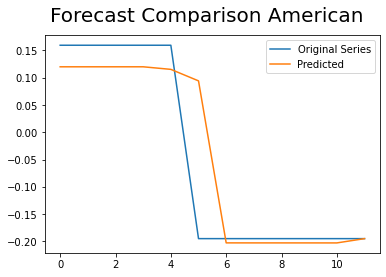

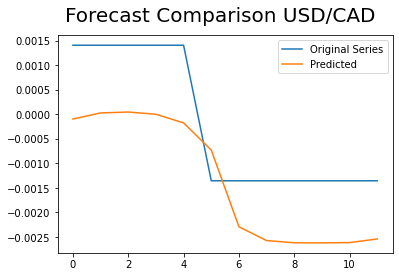

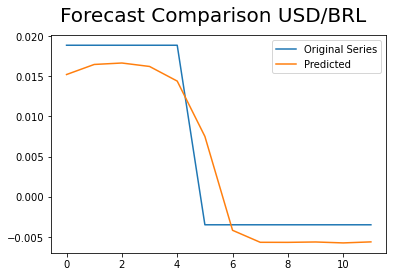

In [15]:
plot_2_series(real=american_y_test,
            model=american_forecast,
            title='Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            title='Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            title='Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

In [16]:
print("\nAmerican Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))


American Forecast Errors
  Error     Value
0  MAPE  0.245993
1    ME  0.003980
2   MAE  0.044206
3   MPE -0.212543
4  RMSE  0.087602

USD/CAD Forecast Errors
  Error     Value
0  MAPE  0.905242
1    ME -0.001144
2   MAE  0.001249
3   MPE -0.028081
4  RMSE  0.001272

USD/BRL Forecast Errors
  Error     Value
0  MAPE  0.606689
1    ME -0.001329
2   MAE  0.003163
3   MPE -0.054032
4  RMSE  0.004044
